## Linear Regression on House price dataset: [Kaggle Link](https://www.kaggle.com/aniketyadav1/bangalore)

In [1]:
#importing modules
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import pickle
import json

In [2]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/HousePriceDataset/')

In [3]:
dataset = pd.read_csv('banglore.csv')
print(dataset.shape)

(13320, 9)


In [4]:
dataset.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [6]:
dataset.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [7]:
#finding columns with missing values and their percentage of missing
dataset.isnull().sum()
missing_values = dataset.isnull().sum().sort_values(ascending= False)
missing_values = pd.DataFrame(data = dataset.isnull().sum().sort_values(ascending = False), columns = ['MissvalCount'])
#adding a new column
missing_values['percent']  = missing_values.MissvalCount.apply(lambda x: '{:.2f}'.format(float(x)/dataset.shape[0]*100))
missing_values = missing_values[missing_values.MissvalCount>0]
missing_values

,MissvalCount,percent
society,5502,41.31
balcony,609,4.57
bath,73,0.55
size,16,0.12
location,1,0.01


# Now for missing values:
We can either opt for imputation of values with mean of columns or removing those rows. Also, we'll remove all all columns where missing value percentage > 33% i.e society.

In [8]:
dataset = dataset.drop(['society'], axis=1)

In [9]:
#dropping rows with any missing values :: here, we don't choose imputation of data
dataset.dropna(inplace = True)

In [10]:
#previously shape was (13320, 9)
# and now
print(dataset.shape)

(12710, 8)


# Dataset Exploration
* Examining the data distributions of the features. Let's first examine the target variable price so as to ensure that it's following normal distribution.

Machine learning algorithms make the assumption that the data is normal distrubuted, when the data fits a normal distribution, we can make statements about the population using analytical techniques.

Skewness  7.875010857060082
Kurtosis 107.3761636710019


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


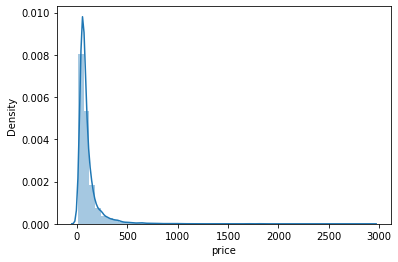

In [11]:
#checking the distribution of target variable:: price
print("Skewness ", dataset['price'].skew())
print("Kurtosis", dataset["price"].kurt())
sns.distplot(dataset.price)

# Observation:
The target variable aka price is highly skewed on the right, let's transform it so that it follows a gaussian normal distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


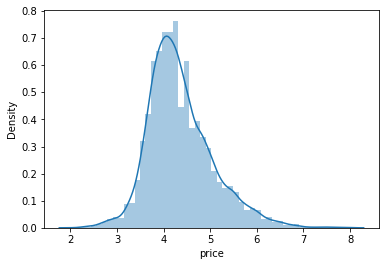

In [12]:
sns.distplot(np.log(dataset.price))


In [13]:
# checking the skewness of each feature.
dataset.skew().sort_values(ascending=False)

price      7.875011
bath       4.590497
balcony    0.005966
dtype: float64

In [14]:
dataset['LogofPrice'] = np.log(dataset.price)
dataset.drop(['price'], axis=1, inplace=True)
print("Skewness ", dataset['LogofPrice'].skew())
print("Kurtosis", dataset["LogofPrice"].kurt())

Skewness  0.8146602488372249
Kurtosis 1.3503351744371508


In [15]:
dataset.head()

,area_type,availability,location,size,total_sqft,bath,balcony,LogofPrice
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,3.665355
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,4.787492
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,4.127134
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,4.553877
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,3.931826


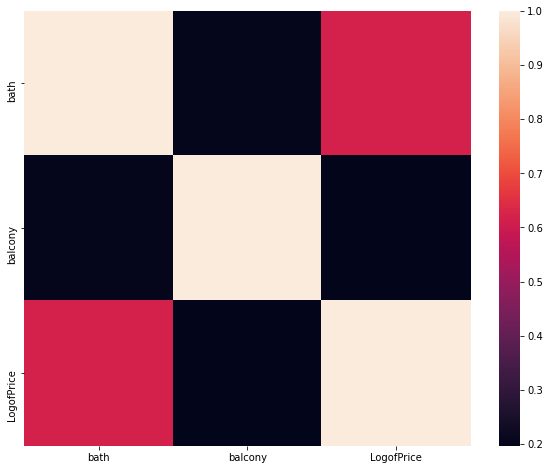

In [16]:
# printing the correlation of data
f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(dataset.corr())

# Pre-processing Stage 
1. converting non-numerical data to numerical dataset

In [17]:
#inspecting unique values in the dataset
##univariate analysis

print(dataset['area_type'].unique())
print("*****************************")
print(dataset['availability'].unique())
print("******************************")
print(dataset['location'].unique())
print("*********************************")
print(dataset["size"].unique())



['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']
*****************************
['19-Dec' 'Ready To Move' '18-Feb' '18-Nov' '18-May' '20-Dec' '17-Oct'
 '21-Dec' '19-Sep' '20-Sep' '18-Mar' '18-Apr' '20-Aug' '19-Mar' '17-Sep'
 '18-Dec' '17-Aug' '19-Apr' '18-Jun' '22-Dec' '22-Jan' '18-Aug' '19-Jan'
 '17-Jul' '18-Jul' '21-Jun' '20-May' '19-Aug' '18-Sep' '17-May' '17-Jun'
 '18-Oct' '21-May' '18-Jan' '20-Mar' '17-Dec' '16-Mar' '19-Jun' '22-Jun'
 '19-Jul' '21-Feb' '19-May' '17-Nov' '20-Oct' '20-Jun' '19-Feb' '21-Oct'
 '21-Jan' '17-Mar' '17-Apr' '22-May' '19-Oct' '21-Jul' '21-Nov' '21-Mar'
 '16-Dec' '22-Mar' '20-Jan' '21-Sep' '21-Aug' '14-Nov' '19-Nov' '16-Jul'
 '15-Jun' '20-Nov' '20-Jul' '16-Sep' '20-Feb' '15-Dec' '16-Oct' '22-Nov'
 '15-Aug' '17-Jan' '16-Nov' '20-Apr' '16-Jan' '17-Feb' '14-Jul']
******************************
['Electronic City Phase II' 'Chikka Tirupathi' 'Uttarahalli' ...
 '12th cross srinivas nagar banshankari 3rd stage' 'Havanur extension'
 'Abshot Layo

In [18]:
#displaying the counts of each
print(dataset['area_type'].value_counts())
print("*****************************")
print(dataset['availability'].value_counts)
print("******************************")
print(dataset['location'].value_counts)
print("*********************************")
print(dataset["size"].value_counts())

Super built-up  Area    8481
Built-up  Area          2310
Plot  Area              1837
Carpet  Area              82
Name: area_type, dtype: int64
*****************************
<bound method IndexOpsMixin.value_counts of 0               19-Dec
1        Ready To Move
2        Ready To Move
3        Ready To Move
4        Ready To Move
             ...      
13314    Ready To Move
13315    Ready To Move
13317    Ready To Move
13318           18-Jun
13319    Ready To Move
Name: availability, Length: 12710, dtype: object>
******************************
<bound method IndexOpsMixin.value_counts of 0        Electronic City Phase II
1                Chikka Tirupathi
2                     Uttarahalli
3              Lingadheeranahalli
4                        Kothanur
                   ...           
13314           Green Glen Layout
13315                  Whitefield
13317       Raja Rajeshwari Nagar
13318             Padmanabhanagar
13319                Doddathoguru
Name: location, Length: 1271

In [19]:
dataset["total_sqft"].value_counts()

1200           788
1100           218
1500           198
2400           177
600            172
              ... 
2316             1
1300 - 1405      1
754              1
2501             1
505              1
Name: total_sqft, Length: 1976, dtype: int64

In [20]:
#dropping duplicates
dataset = dataset.drop_duplicates()

In [21]:
#dropping all NaN values
dataset = dataset.dropna()

In [22]:
dataset.head()

,area_type,availability,location,size,total_sqft,bath,balcony,LogofPrice
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,3.665355
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,4.787492
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,4.127134
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,4.553877
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,3.931826


In [23]:
#extracting size
dataset['size'] = dataset['size'].astype('str')

In [24]:
#extracting bedrooms from size dataframe
dataset['size'].str.extract('([0-9]+\s[A-Z][a-z]+)', expand=True)

,0
0,NaN
1,4 Bedroom
2,NaN
3,NaN
4,NaN
...,...
13312,NaN
13314,NaN
13315,5 Bedroom
13317,NaN


In [25]:
#extracting BHK from size dataframe
dataset['size'].str.extract('([0-9]+\s[A-Z][A-Z]+)', expand=True)

,0
0,2 BHK
1,NaN
2,3 BHK
3,3 BHK
4,2 BHK
...,...
13312,2 BHK
13314,3 BHK
13315,NaN
13317,2 BHK


In [26]:
dataset.head()

,area_type,availability,location,size,total_sqft,bath,balcony,LogofPrice
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,3.665355
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,4.787492
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,4.127134
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,4.553877
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,3.931826


In [27]:
#creating new columns and appending the values
dataset['BHK_size'] = dataset['size']
dataset['bed_size'] = dataset['size']
dataset['BHK_size'] = dataset['size'].str.extract('([0-9]+\s[A-Z][A-Z]+)', expand=True)
dataset['bed_size'] = dataset['size'].str.extract('([0-9]+\s[A-Z][a-z]+)', expand=True)
#extracting numerical data
dataset['BHK_size'] = dataset['BHK_size'].str.extract('([0-9]+)', expand=True)
dataset['bed_size'] = dataset['bed_size'].str.extract('([0-9]+)', expand=True)


In [28]:
dataset.head()

,area_type,availability,location,size,total_sqft,bath,balcony,LogofPrice,BHK_size,bed_size
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,3.665355,2,NaN
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,4.787492,NaN,4
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,4.127134,3,NaN
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,4.553877,3,NaN
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,3.931826,2,NaN


In [29]:
#filling all NAN values with o
dataset['BHK_size'] = dataset['BHK_size'].fillna(0)
dataset['bed_size'] = dataset['bed_size'].fillna(0)

In [30]:
dataset.head()

,area_type,availability,location,size,total_sqft,bath,balcony,LogofPrice,BHK_size,bed_size
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,3.665355,2,0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,4.787492,0,4
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,4.127134,3,0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,4.553877,3,0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,3.931826,2,0


In [31]:
#dropping the redundant size column
dataset = dataset.drop('size', axis=1)

In [32]:
dataset.head()

,area_type,availability,location,total_sqft,bath,balcony,LogofPrice,BHK_size,bed_size
0,Super built-up Area,19-Dec,Electronic City Phase II,1056,2.0,1.0,3.665355,2,0
1,Plot Area,Ready To Move,Chikka Tirupathi,2600,5.0,3.0,4.787492,0,4
2,Built-up Area,Ready To Move,Uttarahalli,1440,2.0,3.0,4.127134,3,0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,1521,3.0,1.0,4.553877,3,0
4,Super built-up Area,Ready To Move,Kothanur,1200,2.0,1.0,3.931826,2,0


In [33]:
#categorising the data in area_type
#creating a dict
#area_type_code = {i:count for i,count in enumerate(dataset['area_type'].unique())}
dataset['area_type'] = dataset['area_type'].map({'Carpet  Area': 0, 'Plot  Area': 1, 'Built-up  Area': 2, 'Super built-up  Area': 3})

In [34]:
dataset.head(10)

,area_type,availability,location,total_sqft,bath,balcony,LogofPrice,BHK_size,bed_size
0,3,19-Dec,Electronic City Phase II,1056,2.0,1.0,3.665355,2,0
1,1,Ready To Move,Chikka Tirupathi,2600,5.0,3.0,4.787492,0,4
2,2,Ready To Move,Uttarahalli,1440,2.0,3.0,4.127134,3,0
3,3,Ready To Move,Lingadheeranahalli,1521,3.0,1.0,4.553877,3,0
4,3,Ready To Move,Kothanur,1200,2.0,1.0,3.931826,2,0
5,3,Ready To Move,Whitefield,1170,2.0,1.0,3.637586,2,0
8,3,Ready To Move,Marathahalli,1310,3.0,1.0,4.147095,3,0
10,3,18-Feb,Whitefield,1800,2.0,2.0,4.248495,3,0
11,1,Ready To Move,Whitefield,2785,5.0,3.0,5.686975,0,4
12,3,Ready To Move,7th Phase JP Nagar,1000,2.0,1.0,3.637586,2,0


In [35]:
#extracting data from availability
dataset['availability'].str.extract('([0-9]+-[A-Z][a-z]+)', expand=True)

,0
0,19-Dec
1,NaN
2,NaN
3,NaN
4,NaN
...,...
13312,NaN
13314,NaN
13315,NaN
13317,NaN


In [36]:
dataset['availability'] = dataset['availability'].replace(to_replace = ['([0-9]+-[A-Z][a-z]+)'],value = 'a',regex = True)

In [37]:
#converting to categorical variable
dataset['availability'] = dataset['availability'].map({'a': 0, 'Ready To Move': 1})

In [38]:
dataset.head()

,area_type,availability,location,total_sqft,bath,balcony,LogofPrice,BHK_size,bed_size
0,3,0,Electronic City Phase II,1056,2.0,1.0,3.665355,2,0
1,1,1,Chikka Tirupathi,2600,5.0,3.0,4.787492,0,4
2,2,1,Uttarahalli,1440,2.0,3.0,4.127134,3,0
3,3,1,Lingadheeranahalli,1521,3.0,1.0,4.553877,3,0
4,3,1,Kothanur,1200,2.0,1.0,3.931826,2,0


In [39]:

dataset['total_sqft'] = dataset['total_sqft'].str.extract('([0-9]+)', expand=True)

In [40]:
dataset.head()

,area_type,availability,location,total_sqft,bath,balcony,LogofPrice,BHK_size,bed_size
0,3,0,Electronic City Phase II,1056,2.0,1.0,3.665355,2,0
1,1,1,Chikka Tirupathi,2600,5.0,3.0,4.787492,0,4
2,2,1,Uttarahalli,1440,2.0,3.0,4.127134,3,0
3,3,1,Lingadheeranahalli,1521,3.0,1.0,4.553877,3,0
4,3,1,Kothanur,1200,2.0,1.0,3.931826,2,0


In [41]:
#dropping location
dataset = dataset.drop('location', axis=1)

In [42]:
#defining the datatypes
dataset['bath'] = dataset['bath'].astype('int')
dataset['total_sqft'] = dataset['total_sqft'].astype('float')
dataset['BHK_size'] = dataset['BHK_size'].astype('int')
dataset['bed_size'] = dataset['bed_size'].astype('int')

In [43]:
#splitting the dataset
X = dataset.drop('LogofPrice', axis=1)
y = dataset['LogofPrice']

print("Shape of Input variable", X.shape)
print("Shape of target variable",y.shape)

Shape of Input variable (12146, 7)
Shape of target variable (12146,)


In [44]:
# splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

print("Shape of Train Input features", X_train.shape)
print("Shape of Train Target feature", y_train.shape)
print("Shape of Test Input features", X_test.shape)
print("Shape of Test Target feature",y_test.shape)


Shape of Train Input features (8502, 7)
Shape of Train Target feature (8502,)
Shape of Test Input features (3644, 7)
Shape of Test Target feature (3644,)


# Feature Scaling Step.
Data Standardization/Normalisation Step.

#Few important points
1. We generally use Standardization when our distribution is normal(Gaussian i.e mean=0 and variance = 1. Clustering, PCA etc often uses standardisation whereas normalisation is often used in Image data where pixel intensities vary between 0-255 and are mostly used in Neural Networks, K-Nearest Networks etc.

2. Not all Machine learning algorithms need feature scaling step as the last step in the data preprocessing stage. Those machine learning algorithms are usually tree based models like Random forest, XGBoost, Decision Trees.

3. Feature scaling plays a vital role in ML algorithms which calculate distances like KNN, K means, SVM , PCA, LDA, Linear Regression, Logistic Regression, Neural Networks. As these models won't be able to adapt to variance/unit fluctuations between the features in the dataset.

Normalisation is often abbreviated as Min-max scaler.

Standardisation ensures that if the input feature is skewed, the output transformed feature also retains the skewness.

Here, we will use Standard Scalar instead of using Min-Max scaler.




In [45]:
FT = StandardScaler()
# it is to be noted that Feature rescaling methods are often fitted on train set and transformed on both Train and test
FT.fit(X_train)
X_train = FT.transform(X_train)
X_test = FT.transform(X_test)

In [46]:
#printing the shape
print("Shape of Train Input features", X_train.shape)
print("Shape of Train Target feature", y_train.shape)
print("Shape of Test Input features", X_test.shape)
print("Shape of Test Target feature",y_test.shape)


Shape of Train Input features (8502, 7)
Shape of Train Target feature (8502,)
Shape of Test Input features (3644, 7)
Shape of Test Target feature (3644,)


# Model Fitting Stage - Without Hyper parameter tuning.
*We* will be training our model using Linear regression and with regularisations like Lasso and Ridge.

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
#printing the coefficients and bias learned by model
print("Weight coeeficient",lr.coef_)
print("Bias",lr.intercept_)

Weight coeeficient [-0.09396121  0.00707761  0.23483391  0.2666961   0.03221701  0.08881661
  0.08825691]
Bias 4.373651347070199


In [49]:
#inferencing stage
out = lr.predict([X_test[0,:]])
#now since the prediction is in log scale, hence we need to convert it back
print("Predicted price is {}K INR".format(np.exp(out[0])))

Predicted price is 64.81440339025005K INR


In [50]:
#calculating the score
lr.score(X_test,y_test)

0.44404275170761387

In [51]:
#using lasso and ridge with alpha 1
ridge = Ridge(alpha=5)
ridge.fit(X_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [52]:
#inferencing stage
out = ridge.predict([X_test[0,:]])
#now since the prediction is in log scale, hence we need to convert it back
print("Predicted price is {}K INR".format(np.exp(out[0])))

Predicted price is 64.82029418283557K INR


In [53]:
#calculating the score
ridge.score(X_test,y_test)

0.444132150668586

In [54]:
#using lasso and ridge with alpha 1
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [55]:
#inferencing stage
out = lasso.predict([X_test[0,:]])
#now since the prediction is in log scale, hence we need to convert it back
print("Predicted price is {}K INR".format(np.exp(out[0])))

Predicted price is 64.47425364709318K INR


In [56]:
#calculating the score
lasso.score(X_test,y_test)

0.4452999164460554

# Observation
Linear Regression with Regulariser(Lasso and Ridge) perform better.


# Model Fitting Stage - With Hyper parameter tuning.


In [57]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,4.0]}
alphareg_linear =  GridSearchCV(Lasso(), 
                               param_grid=lasso_params).fit(X_train, y_train).best_estimator_

In [58]:
alphareg_linear.predict([X_test[0,:]])

array([4.12233035])

In [59]:
alphareg_linear.score(X_test,y_test)

0.452333336444007

Better accuracy with hyper parameter tuning.
Let's create pipelines i.e using polynomial features with Lasso and Ridge

In [60]:
lasso_params = {'lasso__alpha':[0.1,0.5]}
ridge_params = {'ridge__alpha':[550,852]}

LassoPipeline = modelLasso = make_pipeline(
    PolynomialFeatures(8),
    Lasso()
)
RidgePipeline = make_pipeline(PolynomialFeatures(8),Ridge())




In [61]:
#fetching the keys of the pipeline
LassoPipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'polynomialfeatures', 'lasso', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [62]:
RidgePipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'polynomialfeatures', 'ridge', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [64]:

#fitting the models
Lasso_Model = GridSearchCV(LassoPipeline,param_grid= lasso_params,return_train_score=True,n_jobs=4).fit(X_train, y_train).best_estimator_ 
Ridge_Model= GridSearchCV(RidgePipeline, 
                                 param_grid=ridge_params,return_train_score=True,n_jobs=4).fit(X_train, y_train).best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1094.4601917617952, tolerance: 0.41890352182101426
  positive)
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [67]:
#prediction stage
print(Lasso_Model.predict([X_test[0,:]]))
print(Ridge_Model.predict([X_test[0,:]]))

[4.19367898]
[4.13314469]


In [68]:
#calculating the score of Lasso Model
Lasso_Model.score(X_test,y_test)


-68512076.33009388

In [69]:
#calculating the score of Ridge Model
Ridge_Model.score(X_test,y_test)

-14727366546183.172

#Observation:
Clearly with Polynomial features and Lasso/Ridge Regression the scores are not great. You can try to run the Grid Search by putting more samples using np.linspace in lasso__alpha and ridge__alpha.

We'll be saving our best model(Limited to the our extent of experimentation). Feel free to tweak and fit more.

In [70]:
#saving the model for serving
with open('fitted_model.pkl','wb') as f:
    pickle.dump(alphareg_linear,f)


# Resolutions for further enhancements in the accuracy.
1. Better feature vectors.
2. Other ML techniques like Random Forest, XGBoost etc.